<a href="https://colab.research.google.com/github/Marvin2798/CNN-Project-/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project Link : https://github.com/ironhack-labs/project-1-deep-learning-image-classification-with-cnn/blob/main/README.md#project-i--deep-learning-image-classification-with-cnn

1. Loading and Data Processing

In [97]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [98]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


In [99]:
# Import to_categorical
from tensorflow.keras.utils import to_categorical  # Import to_categorical

In [100]:
# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

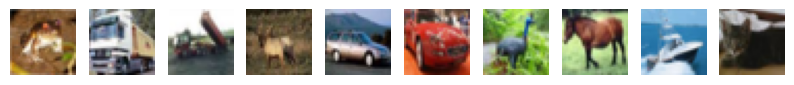

In [101]:
plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()


2. Model Architecture

In [103]:
!pip install tensorflow-addons
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Data augmentation layers specifically tuned for CIFAR-10
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

# Define the model
model = Sequential([
    Input(shape=(32, 32, 3)),
    data_augmentation,

    # First Convolutional Block
    Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Second Convolutional Block
    Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Third Convolutional Block
    Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Dense layers
    Flatten(),
    Dense(128, kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Display model summary
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_9 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_10 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                    

3. Model Training

In [104]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)

# Reduce learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Model checkpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor="val_loss", mode="min", save_best_only=True, verbose=1)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, checkpoint, reduce_lr])
# history = model.fit(x_train, y_train,
#                     batch_size=64,
#                     epochs=200,
#                     validation_split=0.1,
#                     callbacks=[reduce_lr, early_stopping])


Epoch 1/50
781/782 [============================>.] - ETA: 0s - loss: 2.0723 - accuracy: 0.3639
Epoch 1: val_loss improved from inf to 2.03123, saving model to best_model.keras
782/782 [==============================] - 55s 67ms/step - loss: 2.0721 - accuracy: 0.3639 - val_loss: 2.0312 - val_accuracy: 0.4014 - lr: 0.0010
Epoch 2/50
781/782 [============================>.] - ETA: 0s - loss: 1.6909 - accuracy: 0.4891
Epoch 2: val_loss improved from 2.03123 to 1.90293, saving model to best_model.keras
782/782 [==============================] - 51s 66ms/step - loss: 1.6907 - accuracy: 0.4891 - val_loss: 1.9029 - val_accuracy: 0.4527 - lr: 0.0010
Epoch 3/50
781/782 [============================>.] - ETA: 0s - loss: 1.5320 - accuracy: 0.5436
Epoch 3: val_loss improved from 1.90293 to 1.43363, saving model to best_model.keras
782/782 [==============================] - 52s 66ms/step - loss: 1.5320 - accuracy: 0.5436 - val_loss: 1.4336 - val_accuracy: 0.5845 - lr: 0.0010
Epoch 4/50
781/782 [===


  4. Model Evaluation



In [105]:
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


313/313 [==============================] - 4s 11ms/step - loss: 0.7113 - accuracy: 0.8147
Validation Loss: 0.7112933993339539
Validation Accuracy: 0.8147000074386597


In [106]:
from sklearn.metrics import classification_report

# Predict the labels on the validation set
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Print the classification report
print(classification_report(y_true, y_pred_classes))


313/313 [==============================] - 4s 11ms/step
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1000
           1       0.94      0.91      0.92      1000
           2       0.88      0.68      0.77      1000
           3       0.78      0.62      0.69      1000
           4       0.83      0.76      0.79      1000
           5       0.85      0.64      0.73      1000
           6       0.64      0.95      0.77      1000
           7       0.85      0.87      0.86      1000
           8       0.90      0.89      0.90      1000
           9       0.77      0.95      0.85      1000

    accuracy                           0.81     10000
   macro avg       0.83      0.81      0.81     10000
weighted avg       0.83      0.81      0.81     10000



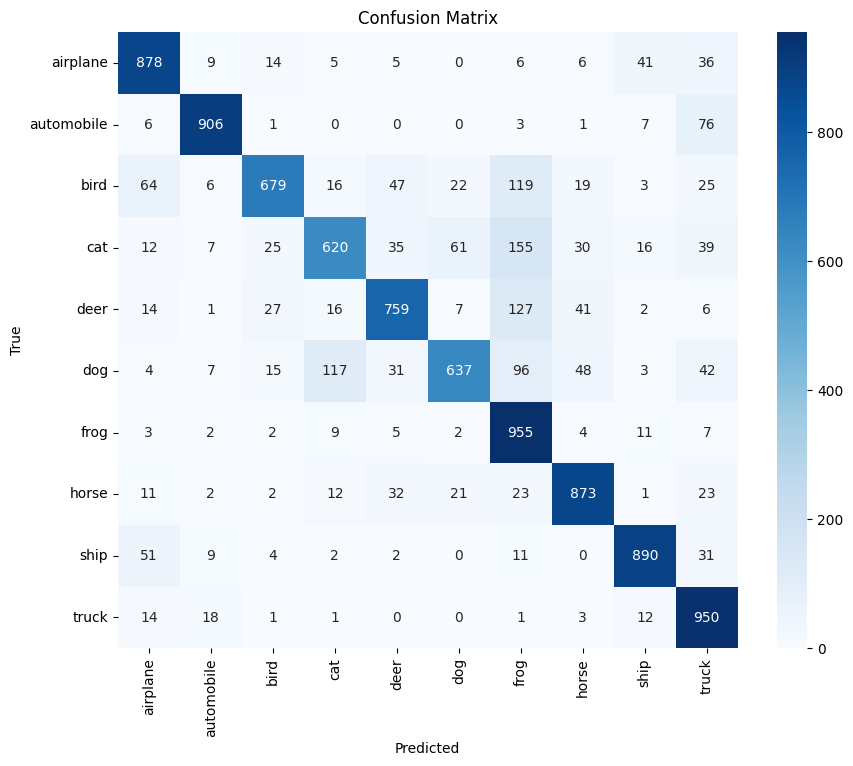

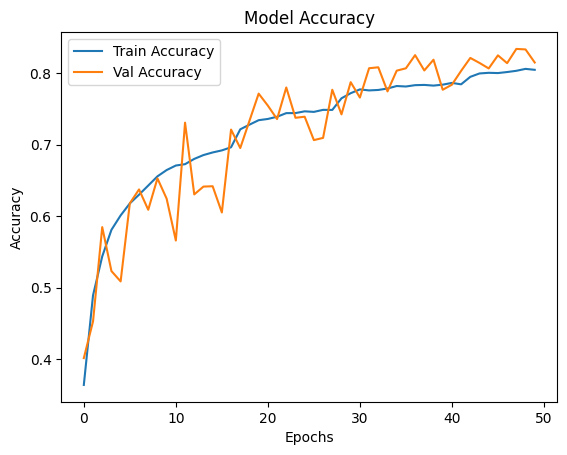

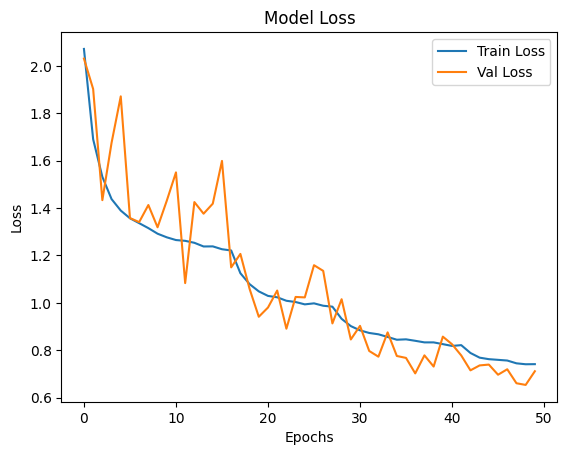

In [107]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#visualize the training and validation accuracy and loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Transfer Learning using VGG16

In [110]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For data augmentation
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load and preprocess CIFAR-10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Normalize the data (VGG16 expects input range from 0 to 1)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Data augmentation to help with generalization
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# Load VGG16 pre-trained model without top layers
base_vgg16 = VGG16(include_top=False, input_shape=(32, 32, 3), weights='imagenet')

# Freeze all layers except the last few
for layer in base_vgg16.layers[:-10]:  # Unfreeze the last 10 layers for fine-tuning
    layer.trainable = False

# Create a new model and add VGG16 as the base
model = Sequential([
    base_vgg16,                    # Using VGG16 as the base model
    Flatten(),                      # Flatten the VGG16 output
    Dense(256, activation='relu'),   # New fully connected layer
    BatchNormalization(),           # Batch Normalization
    Dropout(0.5),                   # Dropout for regularization
    Dense(128, activation='relu'),   # Another fully connected layer
    BatchNormalization(),           # Batch Normalization
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer for CIFAR-10 (10 classes)
])

# Compile the model with a slightly higher learning rate
model.compile(optimizer=Adam(learning_rate=1e-4),  # Start with a slightly higher learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tuning callbacks
fine_tune_early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)  # Restores the best model
fine_tune_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
checkpoint = ModelCheckpoint(filepath='finetuned_model.keras', monitor="val_loss", mode="min", save_best_only=True, verbose=1)

# Fine-tune the model
model.fit(datagen.flow(X_train, y_train, batch_size=64),  # Using data augmentation generator
          validation_data=(X_test, y_test),
          epochs=50,
          callbacks=[fine_tune_reduce_lr, fine_tune_early_stopping, checkpoint])

# Summarize the model architecture
model.summary()



Epoch 1/50
782/782 [==============================] - ETA: 0s - loss: 1.8309 - accuracy: 0.4302
Epoch 1: val_loss improved from inf to 1.19700, saving model to finetuned_model.keras
782/782 [==============================] - 203s 255ms/step - loss: 1.8309 - accuracy: 0.4302 - val_loss: 1.1970 - val_accuracy: 0.6255 - lr: 1.0000e-04
Epoch 2/50
782/782 [==============================] - ETA: 0s - loss: 1.0754 - accuracy: 0.6530
Epoch 2: val_loss improved from 1.19700 to 0.87486, saving model to finetuned_model.keras
782/782 [==============================] - 197s 252ms/step - loss: 1.0754 - accuracy: 0.6530 - val_loss: 0.8749 - val_accuracy: 0.7230 - lr: 1.0000e-04
Epoch 3/50
782/782 [==============================] - ETA: 0s - loss: 0.8891 - accuracy: 0.7134
Epoch 3: val_loss improved from 0.87486 to 0.81930, saving model to finetuned_model.keras
782/782 [==============================] - 197s 252ms/step - loss: 0.8891 - accuracy: 0.7134 - val_loss: 0.8193 - val_accuracy: 0.7418 - lr: 1

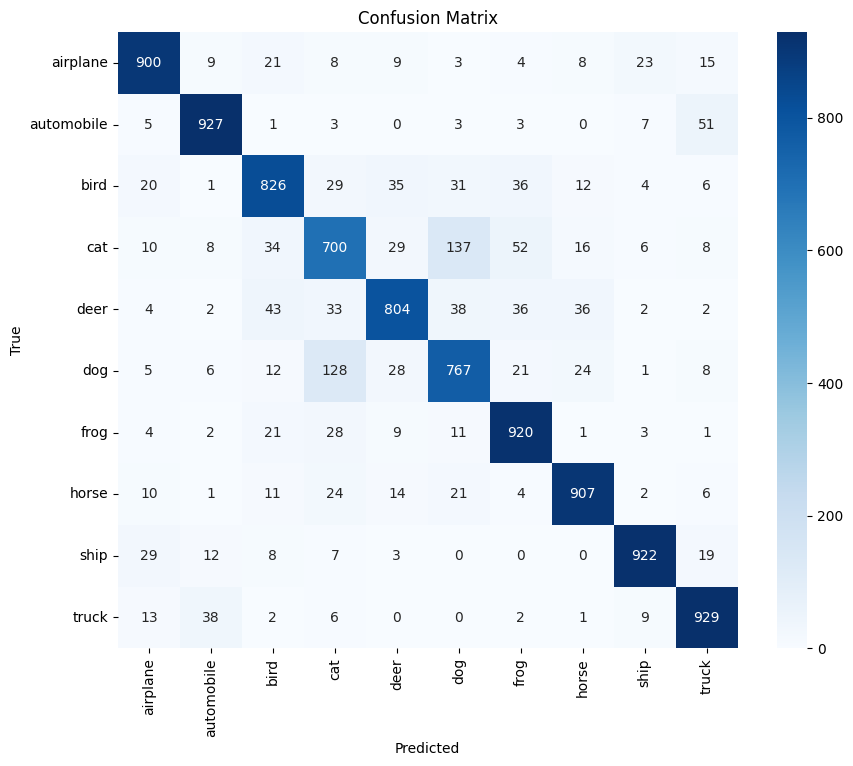

In [120]:
# Loads the weights
model.load_weights('finetuned_model.keras')

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [121]:
#Evaluate Model Performance
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

from sklearn.metrics import classification_report

# Predict the labels on the validation set
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Print the classification report
print(classification_report(y_true, y_pred_classes))


313/313 [==============================] - 12s 37ms/step - loss: 0.5112 - accuracy: 0.8602
Test Loss: 0.5112207531929016
Test Accuracy: 0.8601999878883362
313/313 [==============================] - 12s 37ms/step
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1000
           1       0.92      0.93      0.92      1000
           2       0.84      0.83      0.83      1000
           3       0.72      0.70      0.71      1000
           4       0.86      0.80      0.83      1000
           5       0.76      0.77      0.76      1000
           6       0.85      0.92      0.89      1000
           7       0.90      0.91      0.90      1000
           8       0.94      0.92      0.93      1000
           9       0.89      0.93      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



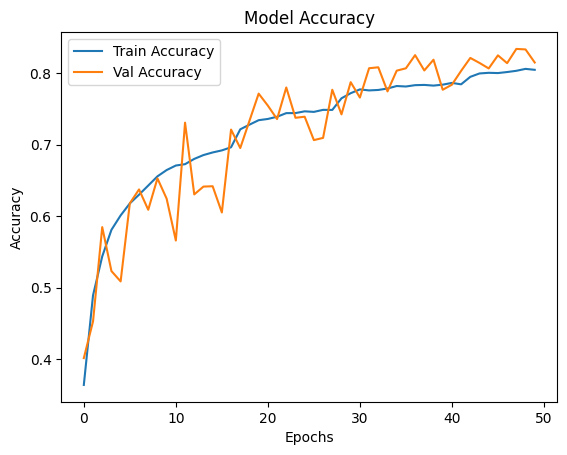

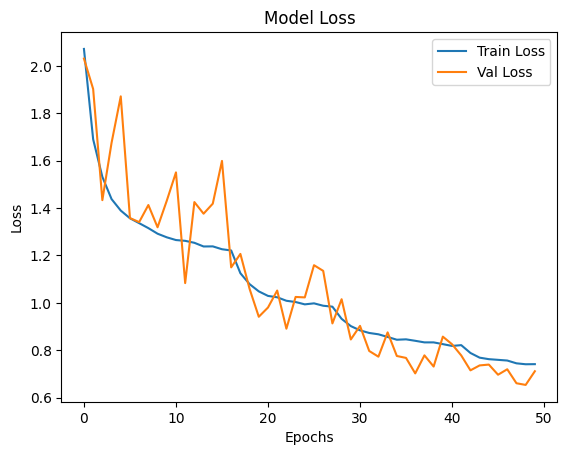

In [122]:
#visualize the training and validation accuracy and loss to see how well the model has learned
import matplotlib.pyplot as plt
model.load_weights('finetuned_model.keras')

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [123]:
#Save the best model. ModelCheckpoint - (best_model.keras) contains the version with the lowest validation loss.
from tensorflow.keras.models import load_model

# Load the saved best model
best_model = load_model('best_model.keras')


Epoch 1/20
782/782 [==============================] - 240s 303ms/step - loss: 0.0754 - accuracy: 0.9791 - val_loss: 0.5603 - val_accuracy: 0.8554 - lr: 1.0000e-05
Epoch 2/20
782/782 [==============================] - 236s 302ms/step - loss: 0.0442 - accuracy: 0.9897 - val_loss: 0.5708 - val_accuracy: 0.8609 - lr: 1.0000e-05
Epoch 3/20
782/782 [==============================] - 237s 303ms/step - loss: 0.0277 - accuracy: 0.9944 - val_loss: 0.6146 - val_accuracy: 0.8605 - lr: 1.0000e-05
Epoch 4/20
782/782 [==============================] - 238s 304ms/step - loss: 0.0185 - accuracy: 0.9974 - val_loss: 0.6390 - val_accuracy: 0.8617 - lr: 1.0000e-05
Epoch 5/20
782/782 [==============================] - 237s 303ms/step - loss: 0.0124 - accuracy: 0.9985 - val_loss: 0.6910 - val_accuracy: 0.8568 - lr: 1.0000e-05
Epoch 6/20
782/782 [==============================] - 235s 301ms/step - loss: 0.0132 - accuracy: 0.9976 - val_loss: 0.7164 - val_accuracy: 0.8613 - lr: 1.0000e-05
Epoch 7/20
782/782 [==

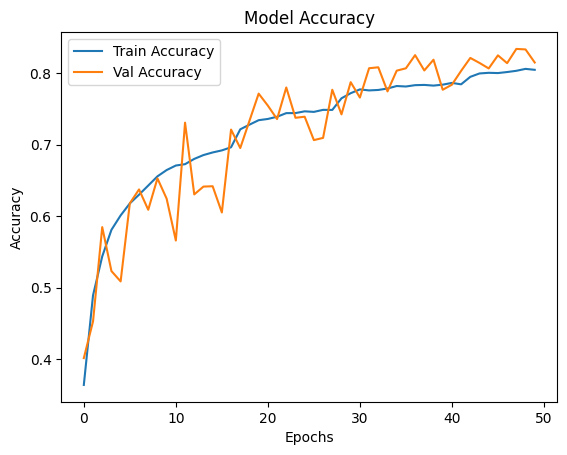

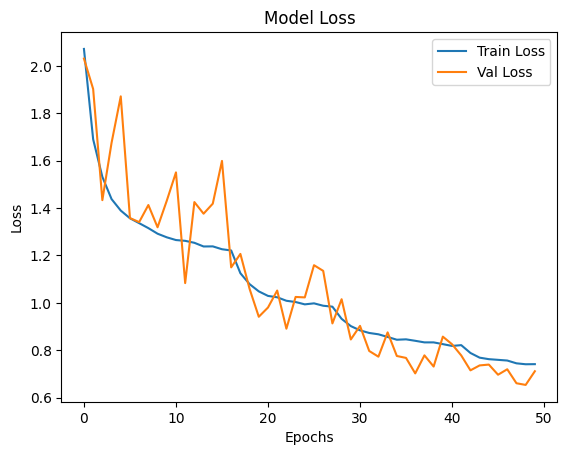

In [124]:
# Unfreeze the last few layers of the VGG16 model for fine-tuning
for layer in base_vgg16.layers[:-20]:  # Keeping the earlier layers frozen
    layer.trainable = False

# Make the last few layers trainable
for layer in base_vgg16.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks for reducing learning rate and early stopping (make sure these are defined earlier)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=False)

checkpoint = ModelCheckpoint(filepath='finetuned_model2.keras', monitor="val_loss", mode="min", save_best_only=True, verbose=1)
# Train the model (fine-tune)
history_fine_tune = model.fit(X_train, y_train,
                              epochs=20,
                              batch_size=64,
                              validation_data=(X_test, y_test),
                              callbacks=[reduce_lr, early_stopping])

#visualize the training and validation accuracy and loss to see how well the model has learned
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




313/313 [==============================] - 12s 37ms/step


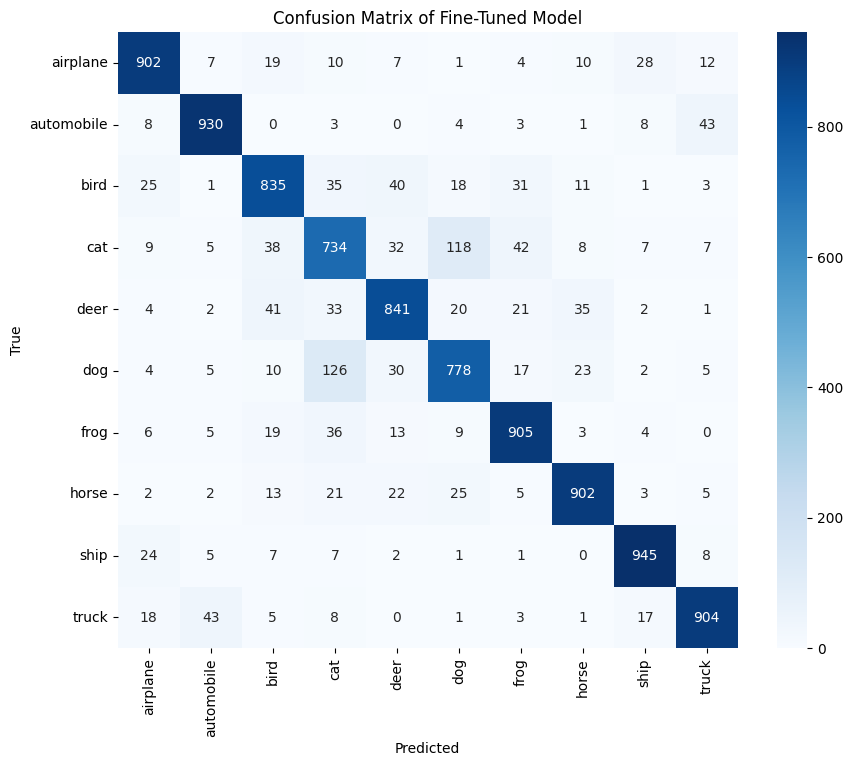

In [125]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_test)  # Use 'model' as this is the fine-tuned model
y_pred_classes_fine_tuned = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)  # Assuming one-hot encoding for y_test

# Generate the confusion matrix for the fine-tuned model


cm_fine_tuned = confusion_matrix(y_true, y_pred_classes_fine_tuned)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_fine_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of Fine-Tuned Model')
plt.show()


Fine-tuning to help the model adapt the pre-trained knowledge to ours

Comparing Confusion Matrices Before and After Fine-Tuning
